In [1]:
import warnings

warnings.filterwarnings("ignore")

# Spatial Inequality Dynamics



In [2]:
import seaborn as sns 
import pandas as pd
import geopandas as gpd
import pysal 
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights

## Data: U.S. state per capita income 1969-2017

For this chapter, we use data on average income per capita over time. Specifically, we consider the United States counties from 1969 to 2017. The U.S. counties are small regions that fit hierarchically within states. This perspective will allow us to examine trends for individual observations (counties), or regions containing several of them in a geographically consistent way (states or census regions which are collections of states). The temporal approach will reveal whether these entities get richer or poorer, as well as how the overall distribution of income moves, skews, or spreads out. 


In [3]:
pci_df = gpd.read_file('https://www.dropbox.com/s/4ihybylqx9b8hun/uscountypcincome.gpkg?dl=1')
pci_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'GeoFIPS', 'GeoName', 'Region',
       'TableName', 'LineCode', 'Descriptio', 'Unit', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
       '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', 'index', 'IndustryCl', 'Descript_1', 'geometry'],
      dtype='object')

In [4]:
pci_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,2012,2013,2014,2015,2016,2017,index,IndustryCl,Descript_1,geometry
0,55,111,01581115,55111,Sauk,Sauk County,06,H1,G4020,357,...,39988,40655,42668,44255,44540,45847,NaN,None,None,"POLYGON ((-90.19196 43.55500, -90.31107 43.553..."
1,55,093,01581107,55093,Pierce,Pierce County,06,H1,G4020,378,...,39121,39367,41626,43539,43488,44636,NaN,None,None,"POLYGON ((-92.69454 44.68874, -92.73204 44.714..."
2,55,063,01581091,55063,La Crosse,La Crosse County,06,H1,G4020,None,...,41759,41230,43637,45067,45985,47134,NaN,None,None,"POLYGON ((-91.34774 43.91196, -91.42519 43.984..."
3,55,033,01581076,55033,Dunn,Dunn County,06,H1,G4020,232,...,35909,35940,36752,36835,37151,38345,NaN,None,None,"POLYGON ((-92.13538 44.94481, -92.15646 45.209..."
4,55,053,01581086,55053,Jackson,Jackson County,06,H1,G4020,None,...,39319,38620,40260,41189,41181,43185,NaN,None,None,"POLYGON ((-91.16601 44.33510, -91.16562 44.596..."



In this dataset, we have 3076 counties across 49 years, as well as 28 extra columns that describe each county. 



In [5]:
pci_df.shape

(3076, 77)

As an example, we can see the first ten years for Jackson County, Mississippi (state code `28`) below:

In [6]:
pci_df.query('NAME == "Jackson" & STATEFP == "28"').loc[
    :, "1969":"1979"
]

,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979
1417,2957,3121,3327,3939,4203,4547,5461,5927,6315,6619,6967


## Global inequality

We begin our examination of inequality by focusing on several global measures of income inequality. Here, "global" means that the measure is concerned with the overall nature of inequality within the income distribution. That is, these measures focus on the direct disparity between rich and poor, considering nothing about where the rich and poor live. Several classic measures of inequality are available for this purpose. 

In general terms, measures of inequality focus on the dispersion present in an income distribution. In the case of regional or spatial inequality, the distributions describe the average or per capita incomes for spatial units, such as for counties, census tracts, or regions. For our U.S. county data, we can visualize (Fig. XXX1XXX) the distribution of per capita incomes for the first year in the sample as follows:

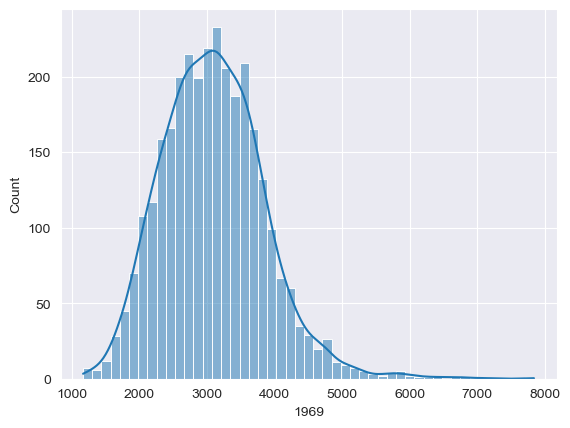

In [7]:
sns.histplot(x=pci_df["1969"], kde=True);

Looking at this distribution, notice that the right side of the distribution is much longer than the left side. This long right tail is a prominent feature, and is common in the study of incomes and many other societal phenomena, as it reflects the fact that within a single income distribution, the super-rich are generally much more wealthy than the super-poor are deprived, compared to the average. 


Before we can get to mapping, we change the CRS to a suitable one for mapping, the Albers Equal Area projection for North America:  

In [8]:
pci_df = pci_df.to_crs(
    # Albers Equal Area North America
    epsg=5070
)

And the quantile choropleth for 1969 (Fig. XXX2XXX) can be generated by:

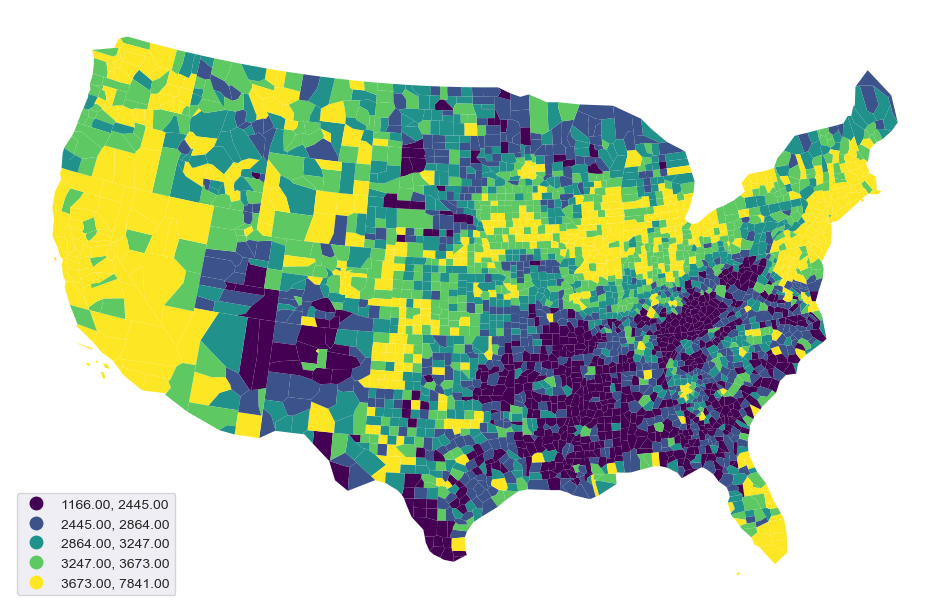

In [9]:
ax = pci_df.plot(
    column="1969",
    scheme="Quantiles",
    legend=True,
    edgecolor="none",
    legend_kwds={"loc": "lower left"},
    figsize=(12, 12),
)
ax.set_axis_off()
plt.show()


### 20:20 ratio

In [10]:
top20, bottom20 = pci_df["1969"].quantile([0.8, 0.2])

In [11]:
top20 / bottom20

1.5022494887525562

Calculate how the 20:20 Ratio changes over time

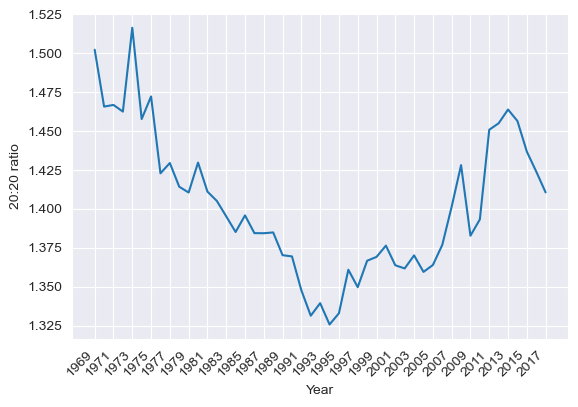

In [12]:
def ineq_20_20(values):
    top20, bottom20 = values.quantile([0.8, 0.2])
    return top20 / bottom20


# Generate range of strings from 1969 to 2018
years = np.arange(1969, 2018).astype(str)
# Compute 20:20 ratio for every year
ratio_2020 = pci_df[years].apply(ineq_20_20, axis=0)
# Plot evolution of 20:20 ratio
ax = plt.plot(years, ratio_2020)

# Grab figure generated in the plot
figure = plt.gcf()
# Replace tick labels with every other year
plt.xticks(years[::2])
# Set vertical label
plt.ylabel("20:20 ratio")
# Set horizontal label
plt.xlabel("Year")
# Rotate year labels
figure.autofmt_xdate(rotation=45)

plt.show()

In addition to the 20:20 ratio, we will explore two more traditional measures of inequality: the Gini index and Theil's index. For these, we will use the `inequality` package from Pysal.

In [13]:
from pysal.explore import inequality

### Gini index and Lorenz Curve
We can construct the Lorenz curve for 1969 by first computing the share of our population of counties that is below each observation. For that, we generate a cumulative series:

In [14]:
n = len(pci_df)
share_of_population = np.arange(1, n + 1) / n
## This is an equally spaced array of numbers

Then, we consider the cumulative evolution of income. For this, we need to find out the proportion of total income owned by each share of the population. Empirically, this can be computed in the following fashion. First, we sort county incomes:

In [15]:
incomes = pci_df["1969"].sort_values()

Second, we find the overall percentage of income accumulated at each data point. To do this, we compute what percentage of the total income each county represents:

In [16]:
shares = incomes / incomes.sum()

In [17]:
shares

2647    0.000122
78      0.000130
2981    0.000131
1047    0.000132
973     0.000136
          ...   
1710    0.000696
2661    0.000701
2901    0.000717
2633    0.000747
1802    0.000824
Name: 1969, Length: 3076, dtype: float64

and construct the *cumulative sum* of these shares, which reflects the sum of all of the shares of income up to the current one:

$$ \texttt{CumSum(v, k)} = \sum_{i=1}^k v_i$$

This starts at $0$ and reaches $1$ once the last share is included:

In [18]:
cumulative_share = shares.cumsum()

With this, we can plot both the Lorenz curve and the line of perfect equality (Fig. XXX4XXX):

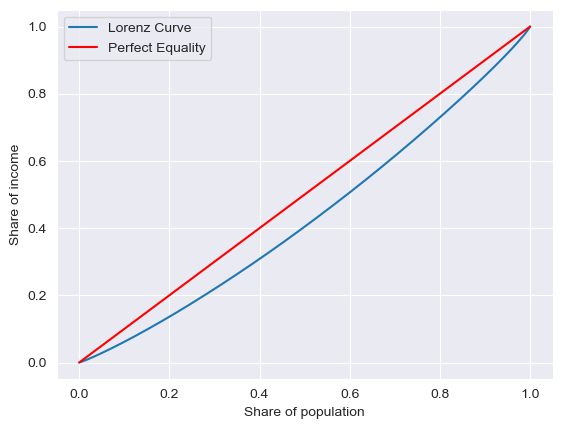

In [19]:
# Generate figure with one axis
f, ax = plt.subplots()
# Plot Lorenz Curve
ax.plot(share_of_population, cumulative_share, label="Lorenz Curve")
# Plot line of perfect equality
ax.plot((0, 1), (0, 1), color="r", label="Perfect Equality")
# Label horizontal axis
ax.set_xlabel("Share of population")
# Label vertical axis
ax.set_ylabel("Share of income")
# Add legend
ax.legend()

plt.show()

The blue line is the Lorenz curve for county incomes in 1969. The Gini index is the area between it and the 45-degree line of equality shown in red, all standardized by the area underneath the line of equality.

A first approach to examine how inequality has evolved is to plot the Lorenz curves for each year. One way to do this in Python involves creating a function that will compute the Lorenz curve for an arbitrary set of incomes. The following function encapsulates the steps shown above into a single shot:

In [20]:
def lorenz(y):
    y = np.asarray(y)
    incomes = np.sort(y)
    income_shares = (incomes / incomes.sum()).cumsum()
    N = y.shape[0]
    pop_shares = np.arange(1, N + 1) / N
    return pop_shares, income_shares

For a single year, say 1969, our function would return a tuple with two arrays, one for each axis in the Lorenz curve plot:

In [21]:
lorenz(pci_df["1969"])

(array([3.25097529e-04, 6.50195059e-04, 9.75292588e-04, ...,
        9.99349805e-01, 9.99674902e-01, 1.00000000e+00]),
 array([1.22486441e-04, 2.52956561e-04, 3.83636778e-04, ...,
        9.98429316e-01, 9.99176315e-01, 1.00000000e+00]))

## Gini inequality in Pysal

In [22]:
g69 = inequality.gini.Gini(pci_df["1969"].values)

To extract the coefficient, we retrieve the `g` property of `g69`:

In [23]:
g69.g

0.13556175504269904

Here, the Gini coefficient in 1969 was 0.13. To compute this for every year, we can use a similar pattern as we have before. First, define a function to compute the quantity of interest; then, apply the function across the table with all years:

In [24]:
def gini_by_col(column):
    return inequality.gini.Gini(column.values).g

`inequality`'s Gini requires an `numpy.ndarray` rather than a `pandas.Series` object, which we can pull out through the `values` attribute. This is passed to the `Gini` class, and we only return the value of the coefficient as a `DataFrame` object.

In [25]:
inequalities = (
    pci_df[years].apply(gini_by_col, axis=0).to_frame("gini")
)

This results in a series of Gini values, one for each year:

In [26]:
inequalities.head()

,gini
1969,0.135562
1970,0.130076
1971,0.128540
1972,0.129126
1973,0.142166


Which we can turn into a graphical representation through standard `pandas` plotting. The resulting pattern (Fig. XXX6XXX) is similar to that of the 20:20 ratio above:

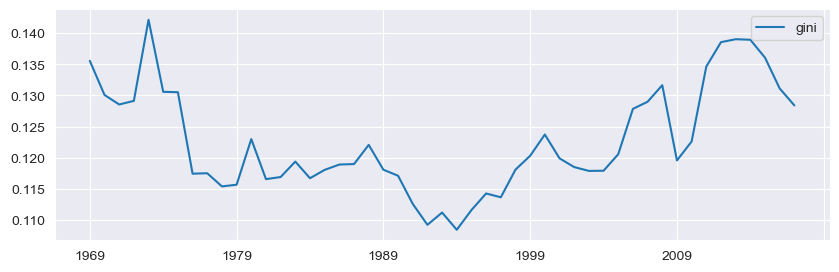

In [27]:
inequalities.plot(figsize=(10, 3));

### Theil's index

A third commonly used measure of inequality is Theil's $T$ {cite}`manz2021` given as:

$$T = \sum_{i=1}^m \left( \frac{y_i}{\sum_{i=1}^m y_i} \ln \left[ m \frac{y_i}{\sum_{i=1}^m y_i}\right] \right)$$

where $y_i$ is per capita income in area $i$ among $m$ areas. Conceptually, this metric is related to the entropy of the income distribution, measuring how evenly distributed incomes are across the population.

The Theil index is also available in Pysal's `inequality`, so we can take a similar approach as above to calculate it for every year:

In [28]:
def theil(column):
    return inequality.theil.Theil(column.values).T


inequalities["theil"] = pci_df[years].apply(theil, axis=0)

And generate a plot of its evolution over time (Fig. XXX7XXX):

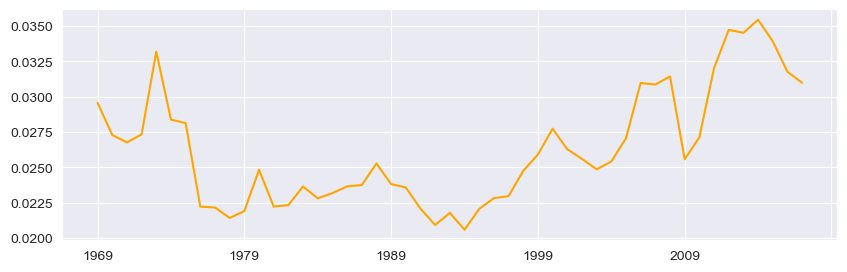

In [29]:
inequalities["theil"].plot(color="orange", figsize=(10, 3));

The time paths of the Gini and the Theil coefficients appear to show striking
similarities. At first glance, this might suggest that the indices are
substitutes for one another. However, if we plot them against each other (Fig. XXX8XXX), we can see they are not perfectly correlated: 

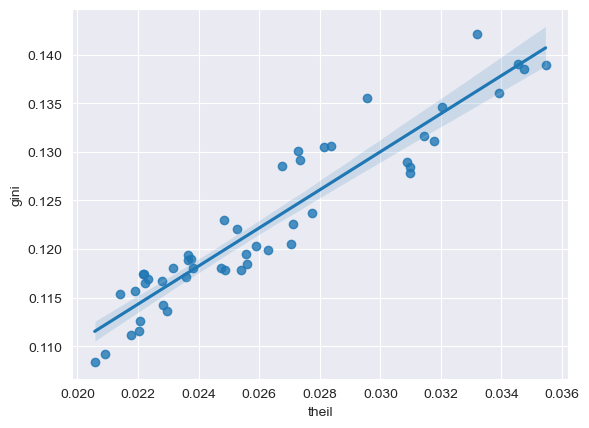

In [30]:
_ = sns.regplot(x="theil", y="gini", data=inequalities)

Indeed, as we shall see below, each index has
properties that lend themselves to particular spatial extensions that work in complementary ways. We need both (and more) for a complete picture. 



## Spatial inequality

The analysis of regional income inequality differs from the analysis of
national interpersonal income inequality in its focus on spatial units. Since
regional incomes are explicitly embedded in geographical space, we can take advantage
of their spatial configuration to learn more about the nature of the inequality.
In the regional inequality literature, this has been approached in a number of ways.
Three are considered in this chapter: one that links the discussion to that of spatial
autocorrelation in Chapters [6](06_spatial_autocorrelation) and [7](07_local_autocorrelation),
a second one based on decomposing global indices regionally, and a third one that embeds space
in traditional global measures.

### Spatial autocorrelation



This approach helps us shed light on the properties of the spatial pattern of regional income data. We return to global measures of spatial autocorrelation that we encountered earlier in the book. The essence of this approach is to examine to what extent the spatial distribution of incomes is concentrated over space. For this, we use a queen spatial weights matrix and calculate Moran's I for
each year in the sample:

In [31]:
wq = weights.Queen.from_dataframe(pci_df)

Following the same pattern to "broadcast" a function, we create a function that returns the results we need from each statistic. Here, we will also keep the pseudo $p$-value for the Moran statistic which, as we saw in [Chapter 6](06_spatial_autocorrelation), helps us identify whether the index is statistically significant under the null hypothesis that incomes are randomly distributed geographically.

In [32]:
def moran_by_col(y, w=wq):
    mo = esda.Moran(y, w=w)
    mo_s = pd.Series(
        {"I": mo.I, "I-P value": mo.p_sim},
    )
    return mo_s

This time, our function returns a `Series` object so that when we pass it through `apply`, we get a well-formatted table:

In [33]:
moran_stats = pci_df[years].apply(moran_by_col, axis=0).T

moran_stats.head()

,I,I-P value
1969,0.649090,0.001
1970,0.647438,0.001
1971,0.626546,0.001
1972,0.606760,0.001
1973,0.640226,0.001


For further comparison, the results are attached to the `inequalities` table:

In [34]:
inequalities = inequalities.join(moran_stats)

Which can be visualized (Fig. XXX9XXX) by:

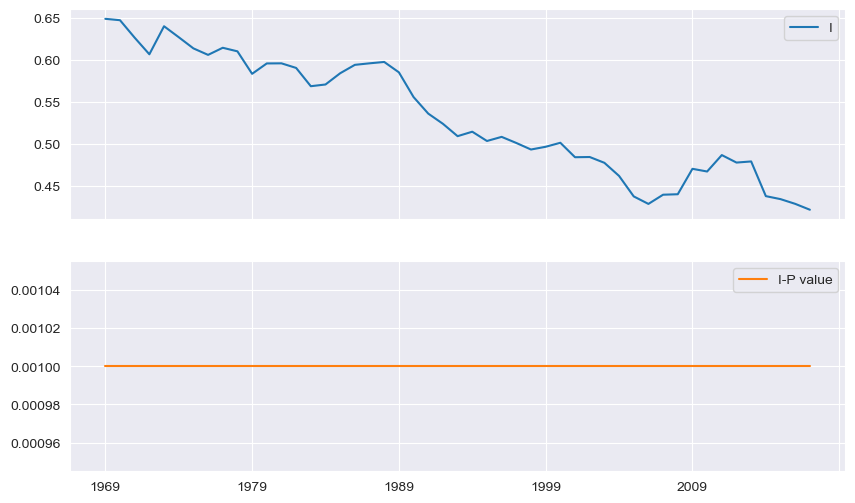

In [35]:
inequalities[["I", "I-P value"]].plot(subplots=True, figsize=(10, 6))
plt.show()

This suggests a gradual decline in the geographic structure of inequality with two implications: 
- (a) per capita incomes are now less similar between nearby counties and 
- (b), this has been consistently declining, regardless of whether inequality is high or low. 
Second, despite this decline, there is never a year in which the spatial autocorrelation is not statistically significant. In other words, there is a strong geographic structure in the distribution of regional incomes that needs to be accounted for when focusing on inequality questions.


## Q.1 (5pts)
Calculate the change in spatial autocorrelation using a different weight, such as: 
- Kernel density
- KNN

In [65]:
# use knn as weights
w_knn = weights.KNN.from_dataframe(pci_df, k=5)
moran_stats_knn = pci_df[years].apply(moran_by_col, axis=0, w=w_knn).T
moran_stats_knn.head()

,I,I-P value
1969,0.658818,0.001
1970,0.659131,0.001
1971,0.634484,0.001
1972,0.612721,0.001
1973,0.644565,0.001


array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

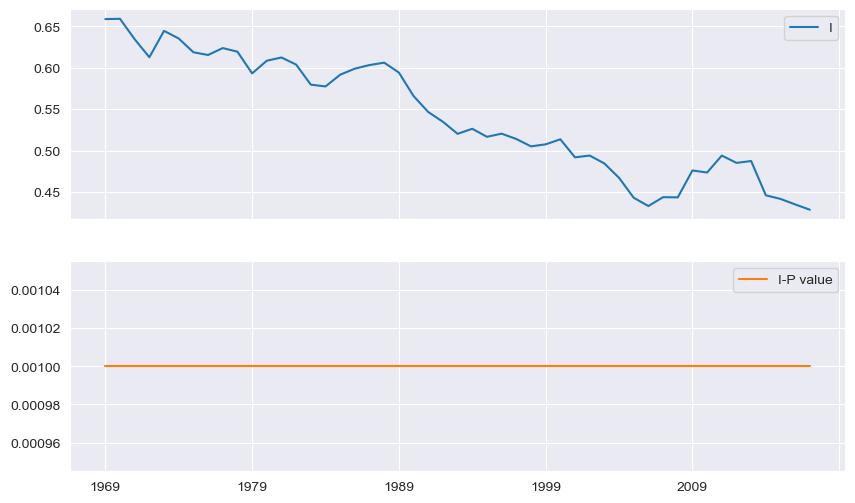

In [67]:
moran_stats_knn.plot(subplots=True, figsize=(10, 6))

## Segregation
We are now going to look at segregation. Let's read a new dataset from the 2018 ACS for NYC

In [36]:
acs_2018 = gpd.read_file('https://www.dropbox.com/s/fa2mzgw8xgo4482/acs_race_income_2018_new.geojson?dl=1')
# acs_2018_3857 = acs_2018.to_crs(epsg=3857)

<AxesSubplot: >

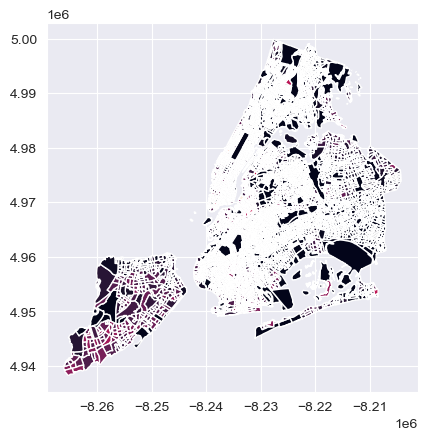

In [37]:
acs_2018.plot('total_pop_white')

In [38]:
acs_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GISJOIN             6592 non-null   object  
 1   total_pop           6592 non-null   int64   
 2   total_pop_hispanic  6592 non-null   int64   
 3   total_pop_white     6592 non-null   int64   
 4   total_pop_black     6592 non-null   int64   
 5   total_pop_native    6592 non-null   int64   
 6   total_pop_asian     6592 non-null   int64   
 7   total_pop_pacific   6592 non-null   int64   
 8   total_pop_other     6592 non-null   int64   
 9   median_hh_income    5705 non-null   float64 
 10  COUNTY              6592 non-null   object  
 11  geometry            6592 non-null   geometry
dtypes: float64(1), geometry(1), int64(8), object(2)
memory usage: 618.1+ KB


In [39]:
from pysal.explore import segregation

### Aspatial
The standard (aspatial) formula for the Dissimilarity index is: 
$$
D = \frac{1}{2}\sum_i^N {\vert \frac{a_i}{A} - \frac{b_i}{B} \vert}
$$

where $a_i$ is the population of group $a$ in tract $i$, $A$ is the total population for group $a$ in the city. $b_i$ is the population for group $b$ in tract $i$ and $B$ is the total population for group $b$.

This is how the Dissimilarity index is implemented in pysal. It assumes a main group of interest and the group "B" is the rest of the population.

### Dissimilarity

In [40]:
dissim = segregation.singlegroup.Dissim(acs_2018, group_pop_var="total_pop_white",total_pop_var="total_pop")

In [41]:
dissim.statistic


0.5878937365977954

### Entropy

In [42]:
entropy = segregation.singlegroup.Entropy(acs_2018, group_pop_var="total_pop_black",total_pop_var="total_pop")
entropy.statistic

0.3612892039303632

### Isolation

In [43]:
isolation = segregation.singlegroup.Isolation(acs_2018, group_pop_var="total_pop_black",total_pop_var="total_pop")
isolation.statistic

0.5001528005208563

### Multigroup Dissimilarity
And there are multi-group variants of these measures. Here is the dissimilarity index.

In [44]:
multi_dissim = segregation.multigroup.MultiDissim(acs_2018, groups=['total_pop_white', 'total_pop_black', 'total_pop_hispanic','total_pop_asian'])


In [45]:
multi_dissim.statistic

0.5554718877585255

## Q.2 (5 pts)
Calculate the black-white dissimilarity for `acs_2018`

In [72]:
acs_2018['total_pop_black_white']=acs_2018['total_pop_black']+acs_2018['total_pop_white']
black_white_dissimilarity = segregation.singlegroup.Dissim(acs_2018, group_pop_var="total_pop_black",total_pop_var="total_pop_black_white")
black_white_dissimilarity.statistic

0.7870921144424972

### Spatial measures (explicit)

In [46]:
cent = segregation.singlegroup.AbsoluteCentralization(acs_2018, group_pop_var="total_pop_black",total_pop_var="total_pop")

In [47]:
cent.statistic


0.20234245540177653

### Spatial measures (implicit)
#### Euclidian distance based measures
We are using a kernel function with `distance` as the kernel bandwidth.

In [48]:
aspatial_gini = segregation.singlegroup.Gini(acs_2018, group_pop_var="total_pop_white",total_pop_var="total_pop")

In [49]:
aspatial_gini.statistic

0.7399259669435013

In [50]:
## Make sure your data is in the right projection so that the distance is in meters
gen_spatialgini =  segregation.singlegroup.Gini(acs_2018, group_pop_var="total_pop_white",total_pop_var="total_pop", distance=2000)


In [51]:
gen_spatialgini.statistic


0.6559885664948056

## Local Measures of Segregation


In [52]:
acs_2018.columns

Index(['GISJOIN', 'total_pop', 'total_pop_hispanic', 'total_pop_white',
       'total_pop_black', 'total_pop_native', 'total_pop_asian',
       'total_pop_pacific', 'total_pop_other', 'median_hh_income', 'COUNTY',
       'geometry'],
      dtype='object')

In [53]:
groups_list = ['total_pop_hispanic', 'total_pop_white',
       'total_pop_black', 'total_pop_native', 'total_pop_asian',
       'total_pop_pacific', 'total_pop_other',]

Let's first take a look at each group's population distribution on a map

### Local entropy

In [54]:
entropy_local = segregation.local.MultiLocalEntropy(acs_2018, groups_list)

In [55]:
acs_2018['local_entropy'] = entropy_local.statistics

<AxesSubplot: >

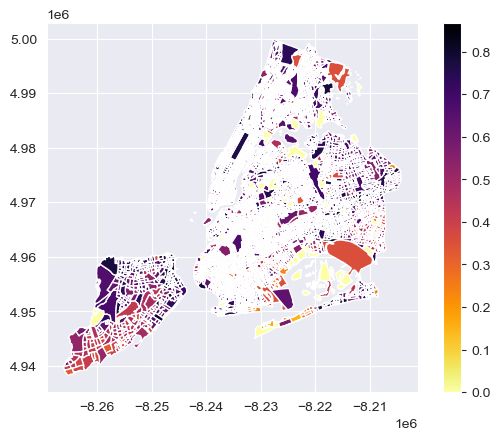

In [56]:
acs_2018.plot('local_entropy', legend=True,cmap='inferno_r')

### Local Centralization
(This might take a few minutes!)

In [57]:
centralization_local = segregation.local.LocalRelativeCentralization(acs_2018, 'total_pop_black', 'total_pop')
acs_2018['local_centralization'] = centralization_local.statistics

<AxesSubplot: >

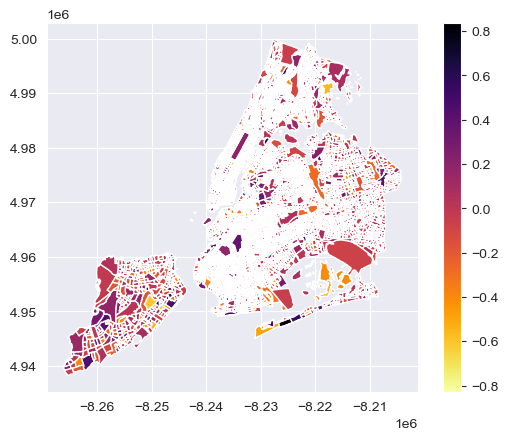

In [58]:
acs_2018.plot('local_centralization', legend=True,cmap='inferno_r')

### Local Simpson Interaction
The is a measure of the probability that two people in a unit (tract here), have the probability of interacting

In [59]:
simpson = segregation.local.MultiLocalSimpsonInteraction(acs_2018, groups_list,w)
acs_2018['local_simpsoninteraction'] = simpson.statistics

NameError: name 'w' is not defined

In [ ]:
acs_2018.plot('local_simpsoninteraction', legend=True,cmap='inferno_r')

## Spatial lags 
Almost all these indices have an option to include a spatial lag. 

In [60]:
wknn = weights.KNN.from_dataframe(acs_2018, k=5)

In [61]:
entropy_spatial = segregation.local.MultiLocalEntropy(acs_2018, groups_list,w=wknn)
acs_2018['local_entropy_spatial'] = entropy_spatial.statistics

<AxesSubplot: >

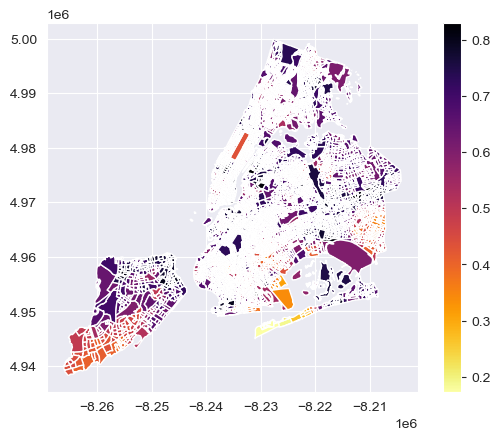

In [62]:
acs_2018.plot('local_entropy_spatial', legend=True,cmap='inferno_r')

In [63]:
simpson_spatial = segregation.local.MultiLocalSimpsonInteraction(acs_2018, groups_list,w=wknn)
acs_2018['local_simpsoninteraction_spatial'] = simpson_spatial.statistics

<AxesSubplot: >

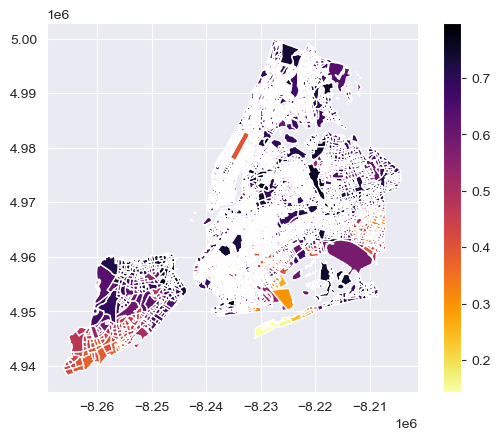

In [64]:
acs_2018.plot('local_simpsoninteraction_spatial', legend=True,cmap='inferno_r')